<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/covid_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os


import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dirname = '/content/drive/My Drive/DD2424_Project/data/'
with open(os.path.join(dirname, 'trainX1.pickle'), 'rb') as f:
  trainX = pickle.load(f)

with open(os.path.join(dirname, 'testX.pickle'), 'rb') as f:
  testX = pickle.load(f)
with open(os.path.join(dirname, 'test_y.pickle'), 'rb') as f:
  test_y = pickle.load(f)


testN = testX.shape[0]
trainN = trainX.shape[0]

In [4]:
dirname = "/content/drive/My Drive/DD2424_Project/"
filename = "model8-undersampling-weights-augmentation.hdf5"
model = keras.models.load_model(os.path.join(dirname, filename))

test_y_pred_m = model.predict(testX)
test_y_pred8 = np.argmax(test_y_pred_m, axis=1)

def lime_predict(images, model=model):
  N = images.shape[0]
  images = images.reshape((N, 224, 224, 1))
  return model.predict(images)

test_y_pred_lime = lime_predict(testX)
test_y_pred8_lime = np.argmax(test_y_pred_lime, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred8, labels=[0, 1, 2])
print("Test set")
print(conf_matrix)
print(classification_report(test_y, test_y_pred8, digits=3))

Test set
[[95  5  0]
 [ 9 89  2]
 [ 2  2 27]]
              precision    recall  f1-score   support

           0      0.896     0.950     0.922       100
           1      0.927     0.890     0.908       100
           2      0.931     0.871     0.900        31

    accuracy                          0.913       231
   macro avg      0.918     0.904     0.910       231
weighted avg      0.914     0.913     0.913       231



---
LIME


In [0]:
# pip install lime

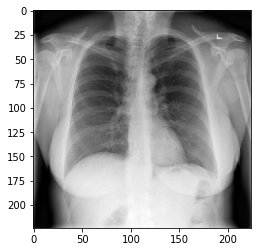

In [6]:
plt.imshow(testX[0], cmap='gray')

In [0]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

lime_explainer = lime_image.LimeImageExplainer()

In [0]:
def lime_predict(images, model=model):
  N = images.shape[0]
  images = images.reshape((N, 224, 224, 3))
  images = images[:, :, :, 0] + images[:, :, :, 1] + images[:, :, :, 2]
  images = images /3.0
  return model.predict(images)


image:  0
explanation top label:  0
prediction:  0
true label:  0


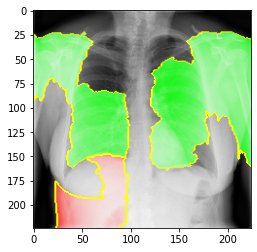

In [9]:
for i in range(1):
  explanation = lime_explainer.explain_instance(image=testX[i], classifier_fn=lime_predict, top_labels=1, hide_color=0, num_samples=1000)
  print("image: ", i)
  print("explanation top label: ", explanation.top_labels[0])
  print("prediction: ", test_y_pred8_lime[i])
  print("true label: ", test_y[i])
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  plt.imshow(mark_boundaries(temp, mask))
  plt.show()

0


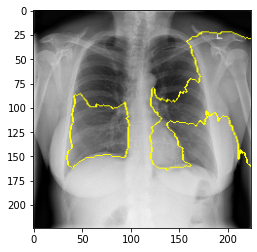

In [10]:
print(explanation.top_labels[0])
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

SHAP

Reshape test set for SHAP

In [0]:
testX = testX.reshape((testN, 224, 224, 1))
trainX = trainX.reshape((trainN, 224, 224, 1))

SHAP for the first 5 images

In [0]:
# pip install shap

In [0]:
import shap
sys.setrecursionlimit(1000000)

shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough
shap.explainers.deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers.deep.deep_tf.passthrough

# we use the first 50 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, trainX[:50, :, :, :])

# explain the first 5 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(testX[:5, :, :, :])

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [0]:
shap_numpy = [s for s in shap_values] 
test_numpy = testX[:5, :, :, :]
shap.image_plot(shap_numpy, -test_numpy)
